In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
batch_size = 8
num_keypoints = 64
depth = 128
training = True
num_heads = 1
num_layers = 2

In [4]:
from superglue.layers import SuperGlue
from superglue.losses import AugmentedSinkhornKnoppLayer, assignment_log_likelihood_from_matrix

In [5]:
model = SuperGlue(depth=depth, num_layers=num_layers, num_heads=num_heads)
optimal_assignment = AugmentedSinkhornKnoppLayer(lam=5, num_steps=100)

In [6]:
input_dA = tf.keras.layers.Input(shape=[num_keypoints, depth])
input_pA = tf.keras.layers.Input(shape=[num_keypoints, 2])

input_dB = tf.keras.layers.Input(shape=[num_keypoints, depth])
input_pB = tf.keras.layers.Input(shape=[num_keypoints, 2])

input_pij_labels = tf.keras.layers.Input(shape=[num_keypoints+1, num_keypoints+1], dtype=tf.float32)

In [7]:
fA, fB = model(input_dA, input_pA, input_dB, input_pB, training=training)

In [8]:
model.summary()

Model: "super_glue"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keypoint_encoder_layer (Keyp (None, 64, 128)           78368     
_________________________________________________________________
attentional_message_passing_ (None, 64, 128)           165760    
_________________________________________________________________
attentional_message_passing_ (None, 64, 128)           165760    
_________________________________________________________________
attentional_message_passing_ (None, 64, 128)           165760    
_________________________________________________________________
attentional_message_passing_ (None, 64, 128)           165760    
_________________________________________________________________
dense_29 (Dense)             (None, 64, 128)           16512     
Total params: 757,920
Trainable params: 754,912
Non-trainable params: 3,008
______________________________________________

In [9]:
fA.shape, fB.shape

(TensorShape([None, 64, 128]), TensorShape([None, 64, 128]))

In [10]:
Pij, Sij = optimal_assignment(fA, fB)

In [11]:
Pij, Sij

(<tf.Tensor 'augmented_sinkhorn_knopp_layer/Identity:0' shape=(None, 65, 65) dtype=float32>,
 <tf.Tensor 'augmented_sinkhorn_knopp_layer/Identity_1:0' shape=(None, 64, 64) dtype=float32>)

In [12]:
super_glue_model = tf.keras.models.Model(inputs=[input_dA, input_pA, input_dB, input_pB], outputs=Pij)

In [13]:
super_glue_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 128)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64, 128)]    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 2)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 2)]      0                                            
______________________________________________________________________________________________

In [14]:
def fake_data_generator():
    while True:
        # left image
        pR = tf.random.uniform([batch_size, num_keypoints, 2])
        dR = tf.random.uniform([batch_size, num_keypoints, depth])

        pL = pR
        dL = dR

        iv = np.array([np.arange(num_keypoints)]*batch_size)
        jv = np.array([np.arange(num_keypoints)]*batch_size)
        
        match_matrix = np.eye(num_keypoints+1)
        match_matrix[-1, -1] = 0
        pij_labels = np.array([match_matrix]*batch_size)
        yield (dR, pR, dL, pL), pij_labels

In [15]:
optimal_assignment.weights

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>]

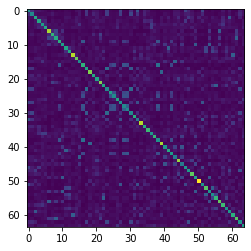

In [16]:
predicted_pij = super_glue_model.predict_generator(fake_data_generator(), steps=1)
plt.imshow(predicted_pij[0][:-1, :-1])

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
super_glue_model.compile(optimizer=optimizer, loss=assignment_log_likelihood_from_matrix)

In [18]:
super_glue_model.fit_generator(fake_data_generator(), epochs=1, steps_per_epoch=50)

50/50 [==============================] - 40s 791ms/step - loss: 59.8360


In [19]:
optimal_assignment.weights

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.051113028>]

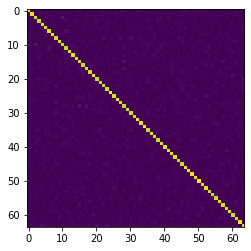

In [20]:
predicted_pij = super_glue_model.predict_generator(fake_data_generator(), steps=1)
plt.imshow(predicted_pij[0][:-1, :-1])